# Image Generation with Autoencoders, Variational Autoencoders, and GANs

## Abstract

This Jupyter Notebook is for applying Autoencoders (AEs), Variational Autoencoders (VAEs) and Generative Adversarial Networks (GANs) to a Pokémon image dataset. 

The dataset source is from [Kaggle](https://www.kaggle.com/vishalsubbiah/pokemon-images-and-types) which contains 809 images along with their types (primary and secondary) as a .csv file. 

In this notebook, it will implement Autoencoders (AEs), Variational Autoencoders (VAEs) and Generative Adversarial Networks (GANs) model to generate fake images which do not exist in the original dataset. The image generatin will be stored in the ouptput file.

Adapted from Autoencoders and Variational Autoencoders Model by Keras in [the Keras blog](https://blog.keras.io/building-autoencoders-in-keras.html), and [pokeGAN](https://github.com/llSourcell/Pokemon_GAN) in GitHub

## Table of contents

* [Autoencoders](#AE)


* [Variational Autoencoders](#VAE)


* [Generative Adversarial Networks](#GAN)

## Autoencoders <a class="anchor" id="AE"></a>

Autoencoders are neural networks that learn to efficiently compress and encode data then learn to reconstruct the data back from the reduced encoded representation to a representation that is as close to the original input as possible. Therefore, autoencoders reduce the dimentsionality of the input data i.e. reducing the number of features that describe input data.

Since autoencoders encode the input data and reconstruct the original input from encoded representation, they learn the identity function in an unspervised manner.

In [1]:
__all__ = ['get_pixel', 'change_image_background', 'create_augmentor_pipeline', 'load_data']

# Cell
import Augmentor
import os
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

# Cell
def get_pixel(image, i, j):
    """ Returns a pixel at coordinate (`i`, `j`). """
    return image.getpixel((i,j))

def change_image_background(orig_dir_path, converted_path):
    """ Changes the image background from white to black and foreground from black to white,
     for all the images at folder `orig_dir_path` and place them into folder `converted_path`."""
    files = os.listdir(dir_path)
    num_files = len(files)
    data = []
    counter = 1
    for f in tqdm(files, total=num_files):
        img = Image.open(os.path.join(dir_path,f))
        out_img = Image.new('RGB',img.size,color=1)
        width, height = img.size
        for w in range(width):
            for h in range(height):
                r, g, b = get_pixel(img, w,h)
                if r > 128 or g > 128 or b > 128:
                    r = g = b = 0
                else:
                    r = g = b = 255
                out_img.putpixel((w,h),(r,g,b))
        file_name = os.path.join(converted_path, str(counter) + '.png')
        out_img.save(file_name)
        counter += 1
    return data


def create_augmentor_pipeline(dir_path):
    """ Creates a pipeline for generating extra images from images at folder `dir_path`."""
    p = Augmentor.Pipeline(dir_path)
    p.resize(probability=1,width=64,height=64)
    p.rotate90(probability=0.1)
    p.rotate(probability=0.2, max_left_rotation=5, max_right_rotation=10)
    p.skew_left_right(probability=0.1)
    p.greyscale(probability=1)
    return p


def load_data(dir_path):
    """ Loads all the images from directory `dir_path`, converts them to matrices and return a list."""
    files = os.listdir(dir_path)
    num_files = len(files)
    data = []
    for f in tqdm(files, total=num_files):
        img = Image.open(os.path.join(dir_path,f))
        img_array = np.array(img)
        data.append(img_array)
    return data

#### Prepare Images data

In [2]:
# Change the background to black and foreground to white

dir_path = os.path.join('data','/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/images')

In [3]:
p = create_augmentor_pipeline(dir_path)

# Generate  10000 images of (64 x 64) according to the pipeline and put them in `data/converted/output` folder

num_samples = 10000
p.sample(num_samples)

Executing Pipeline:   0%|          | 0/10000 [00:00<?, ? Samples/s]

Initialised with 809 image(s) found.
Output directory set to /Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/images/output.

/Users/shu-ya/opt/anaconda3/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Processing <PIL.Image.Image image mode=L size=64x64 at 0x7FA72D8C61C0>: 100%|██████████| 10000/10000 [00:23<00:00, 423.29 Samples/s]


In [4]:
# Load all the images and return a list having array representation of each image

dir_path = os.path.join('/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/images/output')
data = load_data(dir_path)

100%|██████████| 30000/30000 [00:14<00:00, 2098.06it/s]


#### Split Train and Test sets

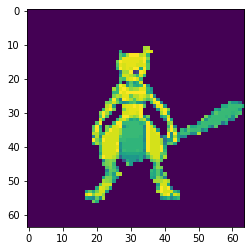

In [5]:
# Split the dataset into 80% train and 20% test sets.
train_data,test_data,_,_ = train_test_split(data,data,test_size=0.2)
train_data = np.array(train_data)
test_data = np.array(test_data)

# Select a random image and display it
sample = 20
img = Image.fromarray(train_data[sample])
plt.imshow(img)

In [6]:
# Normalizing train and test data
normalized_train_data = train_data.astype('float32')/255.0
normalized_test_data = test_data.astype('float32')/255.0

# Reshaping train and test sets, changing from (64, 64) to (64, 64, 1)
normalized_train_data = np.expand_dims(normalized_train_data,axis=-1)
normalized_test_data = np.expand_dims(normalized_test_data,axis=-1)
print('Normalization and reshaping is done.')
print('Input shape = {}'.format(normalized_train_data.shape[1:]))

Normalization and reshaping is done.
Input shape = (64, 64, 1)


#### Define the Encoder

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Conv2DTranspose, Flatten
from tensorflow.keras.layers import Reshape, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import TensorBoard

image_width  = 64
image_height = 64
n_epochs     = 15
batch_size   = 128

input_img = Input(shape=(image_width, image_height, 1))  

# Experiment with the encoder layers
x = Conv2D(32, (3, 3), activation='relu', strides=2, padding='same')(input_img)
x = Conv2D(64, (3, 3), activation='relu', strides=2, padding='same')(x)

# Save the shape into a variable for the decoder use.
encoded_shape = K.int_shape(x)

x = Flatten()(x)
encoded = Dense(128)(x)

# Build the encoder
encoder = Model(input_img,encoded,name='encoder')

# 128-dimensional
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 dense (Dense)               (None, 128)               2097280   
                                                                 
Total params: 2,116,096
Trainable params: 2,116,096
Non-trainable params: 0
_________________________________________________________________


#### Define the Decoder

In [8]:
# Input shape for decoder
encoded_input = Input(shape=(128,))
x = Dense(np.prod(encoded_shape[1:]))(encoded_input)
x = Reshape((encoded_shape[1], encoded_shape[2], encoded_shape[3]))(x)
x = Conv2DTranspose(64,(3, 3), activation='relu',strides=2, padding='same')(x)
x = Conv2DTranspose(32,(3, 3), activation='relu', strides=2, padding='same')(x)
x = Conv2DTranspose(1,(3, 3), activation='sigmoid', padding='same')(x)

decoder = Model(encoded_input,x,name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128)]             0         
                                                                 
 dense_1 (Dense)             (None, 16384)             2113536   
                                                                 
 reshape (Reshape)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 64, 64, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 64, 64, 1)        289 

#### Define the Autoencoder

In [9]:
autoencoder = Model(input_img, decoder(encoder(input_img)),name="autoencoder")
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 encoder (Functional)        (None, 128)               2116096   
                                                                 
 decoder (Functional)        (None, 64, 64, 1)         2169217   
                                                                 
Total params: 4,285,313
Trainable params: 4,285,313
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Compile and train the model. Log and visualize using tensorboard
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

h = autoencoder.fit(normalized_train_data, normalized_train_data,
                epochs=n_epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(normalized_test_data, normalized_test_data),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/15
188/188 [==============================] - 77s 408ms/step - loss: 0.2352 - val_loss: 0.1765
Epoch 2/15
188/188 [==============================] - 87s 465ms/step - loss: 0.1591 - val_loss: 0.1528
Epoch 3/15
188/188 [==============================] - 85s 451ms/step - loss: 0.1432 - val_loss: 0.1419
Epoch 4/15
188/188 [==============================] - 88s 469ms/step - loss: 0.1354 - val_loss: 0.1350
Epoch 5/15
188/188 [==============================] - 96s 513ms/step - loss: 0.1306 - val_loss: 0.1312
Epoch 6/15
188/188 [==============================] - 83s 444ms/step - loss: 0.1271 - val_loss: 0.1284
Epoch 7/15
188/188 [==============================] - 83s 439ms/step - loss: 0.1245 - val_loss: 0.1266
Epoch 8/15
188/188 [==============================] - 79s 422ms/step - loss: 0.1226 - val_loss: 0.1252
Epoch 9/15
188/188 [==============================] - 80s 424ms/step - loss: 0.1214 - val_loss: 0.1248
Epoch 10/15
188/188 [==============================] - 84s 448ms/step - l

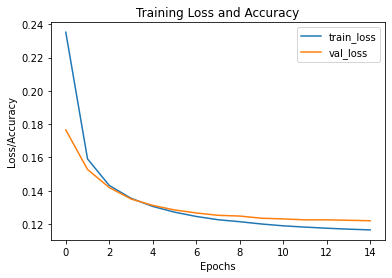

In [11]:
# plot the train and validation losses
N = np.arange(0, n_epochs)
plt.figure()
plt.plot(N, h.history['loss'], label='train_loss')
plt.plot(N, h.history['val_loss'], label='val_loss')
plt.title('Training Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.legend(loc='upper right')

In [12]:
# Make predictions on the test set
decoded_imgs = autoencoder.predict(normalized_test_data)

In [13]:
def visualize(model, X_test, n_samples): 
    """ Visualizes the original images and the reconstructed ones for `n_samples` examples 
    on the test set `X_test`."""
      
    # Reconstructing the encoded images 
    reconstructed_images = model.predict(X_test) 
      
    plt.figure(figsize =(20, 4)) 
    for i in range(1, n_samples): 
          
        # Generating a random to get random results 
        rand_num = np.random.randint(0, 2000) 
      
        # To display the original image 
        #ax = plt.subplot(2, 10, i) 
        #plt.imshow(X_test[rand_num].reshape(image_width, image_width)) 
        #plt.gray() 
        #ax.get_xaxis().set_visible(False) 
        #ax.get_yaxis().set_visible(False) 
  
        # To display the reconstructed image 
        ax = plt.subplot(2, 10, i + 10) 
        plt.imshow(reconstructed_images[rand_num].reshape(image_width, image_width)) 
        #plt.gray() 
        ax.get_xaxis().set_visible(False) 
        ax.get_yaxis().set_visible(False) 
          
    # Displaying the plot 
    plt.show() 

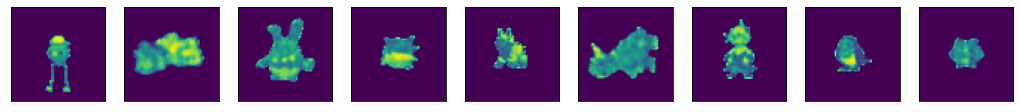

In [14]:
# Plots `n_samples` images. Top row is the original images and the lower row is the reconstructed ones.

n_samples = 10
visualize(autoencoder,normalized_test_data, n_samples)

#### Use another method to generate images - Augmentor: Data Augmentation Tool Library

The purpose of Augmentor is to automate image augmentation (artificial data generation) in order to expand datasets as input for machine learning algorithms, especially neural networks and deep learning.

In [15]:
pip install Augmentor --upgrade

Note: you may need to restart the kernel to use updated packages.


Load a Pipeline object that points to a directory on your file system:

In [16]:
import Augmentor

p = Augmentor.Pipeline("/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images")

Initialised with 809 image(s) found.
Output directory set to /Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output.

Add operations to the Pipeline object p as follows:

Every function requires you to specify a probability, which is used to decide if an operation is applied to an image as it is passed through the augmentation pipeline.

In [17]:
p.random_erasing(probability = 1, rectangle_area = 0.5)
p.random_distortion(probability = 1, grid_height = 5, grid_width = 16, magnitude = 8)
p.shear(probability = 1, max_shear_left = 15, max_shear_right = 15)

Generate 10,000 augmented images based on specifications: 

By default these will be written to the disk in a directory named output relative to the path specified when initialising the p pipeline object above.

In [18]:
p.sample(40)

Processing <PIL.Image.Image image mode=P size=120x120 at 0x7FA72C7F1490>: 100%|██████████| 40/40 [00:00<00:00, 132.24 Samples/s]  


Display the adjusted new images from the output file:

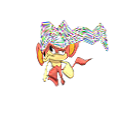

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_pansear.png_739ca3a9-6366-4fcc-80a0-cece27e6dacf.png


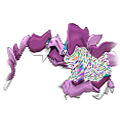

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_drapion.png_4ac90801-bff3-44ed-9a31-b5eba3931efe.png


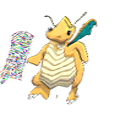

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_dragonite.png_1af6b3a8-eb62-4aa7-866e-15f03670d205.png


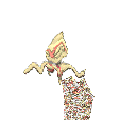

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_baltoy.png_3455f563-1216-4427-9ab5-917de39615e7.png


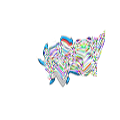

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_marill.png_876bfc29-efa1-4678-b126-2e2dff547ee6.png


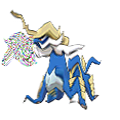

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_samurott.png_1b4f7004-75a3-4bb4-8bf1-7364078c01aa.png


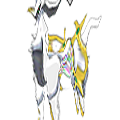

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_arceus.png_1a4384c6-4f6e-44fa-9406-99163fffd0e1.png


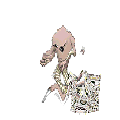

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_hitmonlee.png_dd62eac3-e0c2-488a-b967-7a9f2278c703.png


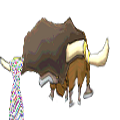

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_bouffalant.png_b25fe7cb-25f5-4982-8aa2-3503df3af9e0.png


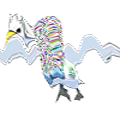

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_swanna.png_23e908f5-0f58-4220-8e7f-1dfee2d1d941.png


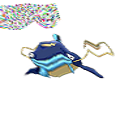

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_whiscash.png_0a5917b4-1d85-4873-bd7a-e88f0bea14ed.png


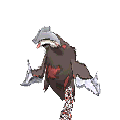

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_excadrill.png_09afddf2-cd34-4f3b-9f76-c2771534448a.png


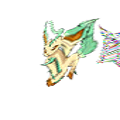

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_leafeon.png_79a5e7a1-6f0c-4e72-8d15-04d589f246ff.png


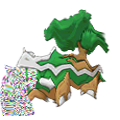

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_torterra.png_f1cd553b-c516-400b-890f-790cceb5bbc0.png


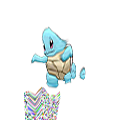

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_squirtle.png_270642a9-dacc-4a4f-b6bd-db06f8761b5e.png


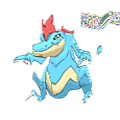

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_feraligatr.png_28e9557b-2427-4a4d-ba88-a7a64b2b7a2d.png


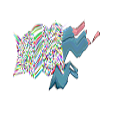

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_misdreavus.png_cdcd811b-a927-4706-8a81-6aa9666ffe35.png


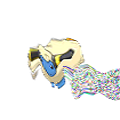

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_mareep.png_f2ba68e8-fec3-4df0-b0c0-3677c99d13f7.png


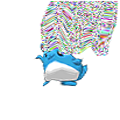

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_marill.png_b9edfa0b-d6ea-4b72-9d33-ebede95dbb8a.png


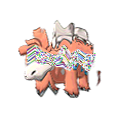

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_camerupt.png_81d6b420-4211-4ce6-8152-57a40e084c7d.png


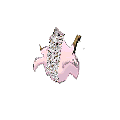

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_clefairy.png_16f39ead-c3ee-4a1c-9795-3465bf454f60.png


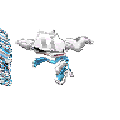

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_meditite.png_cd54b24c-72b2-4b3e-b620-fd913f1402d3.png


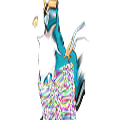

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_cobalion.png_52b4f692-1e15-4c5f-86f0-a37ead8ecf25.png


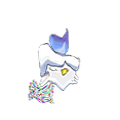

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_litwick.png_1cbd56dc-7c14-4018-8184-0a2537e8c537.png


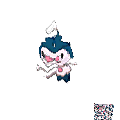

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_mime-jr.png_b8be162c-b7bf-43ea-a7cd-3381fdd0ea2c.png


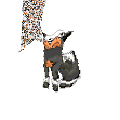

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_houndour.png_e1448c39-5280-4646-a724-43b6d2566ecb.png


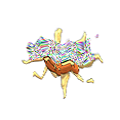

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_solrock.png_c8840fdf-ff4d-4bff-a300-fb782343312b.png


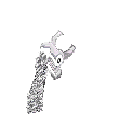

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_castform.png_c48dd7e7-a404-4bb7-bcb6-fa6217e82381.png


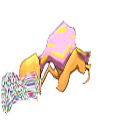

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_parasect.png_1ae546c3-05e2-4d93-8255-388532da3ec9.png


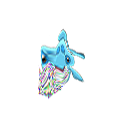

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_phione.png_4af33293-dcd0-4285-9702-b66d605e27f6.png


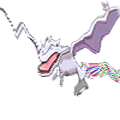

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_aerodactyl.png_a1ab17a6-4645-49d6-bf38-41ad70600bba.png


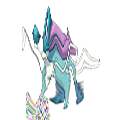

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_suicune.png_25720591-1545-44f7-ab4d-05e202b24e33.png


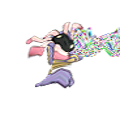

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_lileep.png_44cba3d3-c4c3-4dbc-b9ca-eb3e1c379cf7.png


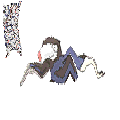

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_drilbur.png_c02aa88f-92f7-4788-a867-24bf327eb6c3.png


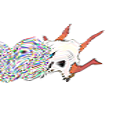

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_larvesta.png_08fb9de8-80f0-4c8a-b5b4-159f2c77720d.png


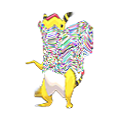

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_ampharos.png_e8162f52-671c-4482-b6ec-8fb6fbeb25ff.png


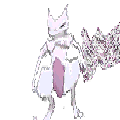

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_mewtwo.png_076f19aa-016e-43d5-b270-d1019cb343a3.png


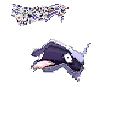

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_shellder.png_74eec24c-50eb-447a-8d00-599d94c7e296.png


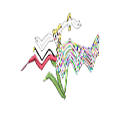

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_flabebe.png_9cdf6644-677f-4ddb-95f1-15570c7cfee7.png


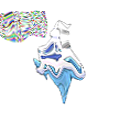

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_vanillish.png_103c68a9-28c2-449b-bd05-8acc16a0eddd.png


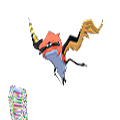

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_fletchinder.png_f618017a-68eb-4820-93bd-3e6953e53aff.png


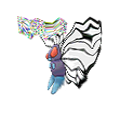

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_butterfree.png_4ef4e54c-7211-4a0f-8a6c-0cd2a981a893.png


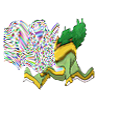

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_grotle.png_1053b746-9fbb-4366-8d40-67050daff882.png


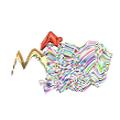

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_pidgeotto.png_ad05d41a-c05d-4cee-bcb2-b145c189a057.png


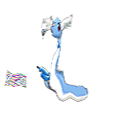

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_dragonair.png_282fcd48-8a69-4a26-aa9d-da6e32ab9d6f.png


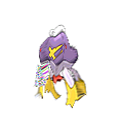

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_drifblim.png_8ceeaa25-a977-47ef-b600-eaafc2c0e09f.png


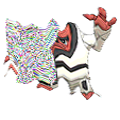

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_throh.png_a86a3bec-00e7-43c8-bbd6-23eabad67931.png


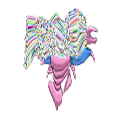

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_gligar.png_32410cc5-e15b-4f0c-bd64-bc7a7ab09449.png


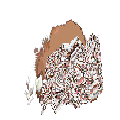

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_piloswine.png_d3688373-2e5f-4de3-badc-b2a21ff95c4c.png


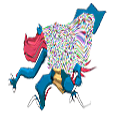

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_druddigon.png_d745b4d5-1da2-42ba-9dac-610d8377cfbf.png


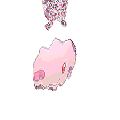

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_munna.png_6d9130b3-ba4b-4c8c-98e5-3678f704072a.png


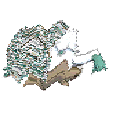

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_snover.png_8d55bae7-e999-441d-988d-a558aaaa1b77.png


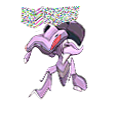

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_genesect.png_a742b36c-87de-4adb-81cb-0962600e45fa.png


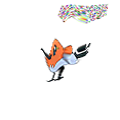

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_fletchling.png_8e774506-cc39-4f0e-9b96-c6a78415cd8f.png


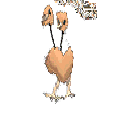

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_doduo.png_96b31914-1542-4bae-9ba0-7cc7eaf99ce6.png


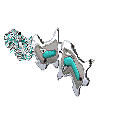

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_klink.png_88e25ab0-3a80-4b41-90fe-849d176e83d7.png


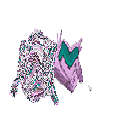

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_nidorino.png_07bb15f1-9ef4-4e49-900f-6d18484d781e.png


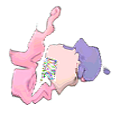

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_musharna.png_549f406c-c2bf-44bf-8386-e5ea33e02822.png


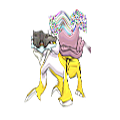

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_raikou.png_79da7e7d-3268-47ab-b61e-d85caf17e6d8.png


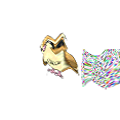

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_pidgey.png_1bb499ca-c085-48f0-a5ce-bdb2b30c8990.png


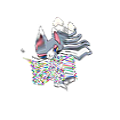

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_glameow.png_c8852c84-bfee-4d63-9be5-9ed96c31b94c.png


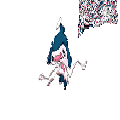

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_mime-jr.png_f6af6b37-8b1b-480b-b98a-c0f90405be75.png


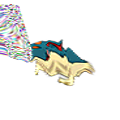

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_quilava.png_0cbdf46d-c334-467b-829e-c4cb13a6365b.png


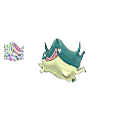

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_qwilfish.png_d443f7cc-cb26-4bd7-965c-0751b65eff69.png


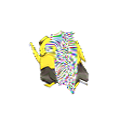

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_drowzee.png_92d607e4-c3f5-4a70-9a03-148454f8248d.png


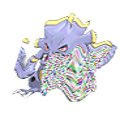

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_exploud.png_a2417efb-816e-446f-beed-a4e7c6b3a63d.png


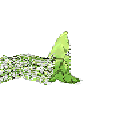

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_metapod.png_3fed5c0b-4026-4da3-95d6-cb13d6c33353.png


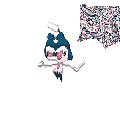

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_mime-jr.png_75b5365e-1a0e-4175-9ee9-07006204112b.png


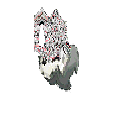

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_duskull.png_fa03dab0-f6fe-4b80-9185-ce2db2971ef5.png


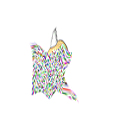

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_weedle.png_79f21d67-a9a3-4ec9-b87c-c74f60b5c871.png


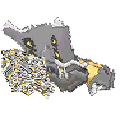

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_bastiodon.png_d7c5db34-bd9d-4d9e-b3c8-157b934d4b38.png


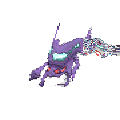

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_sableye.png_515d0c1f-73dd-4c5d-ab41-5ead4c3ee4d7.png


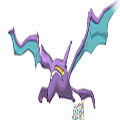

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_crobat.png_022eba64-521a-4af6-9b08-9ce2d8c96b9b.png


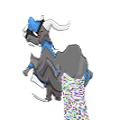

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_rampardos.png_11651434-3141-4330-b6e9-0f1ad8314fcc.png


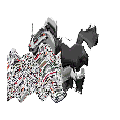

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_mightyena.png_6d238258-360e-447e-94f7-b0aedc111994.png


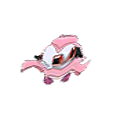

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_spritzee.png_a34cb8e1-9a95-498f-8fd1-16efc69c539e.png


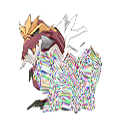

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_tyrantrum.png_3a74ab9b-4836-4588-8f8c-9a3102d07f90.png


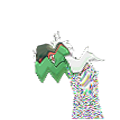

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_basculin-red-striped.png_2d72ae5e-6457-4b2d-b7a0-809c2377c4ac.png


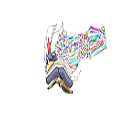

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_rufflet.png_52669052-71e2-443c-bc32-5f6e5c4ab48e.png


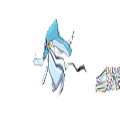

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_azelf.png_14faeec1-986a-4cbc-a21b-a03fb8ce1e03.png


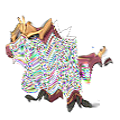

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_tyrantrum.png_637bf027-64a2-4899-b565-a16fd9e8b8ed.png


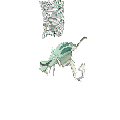

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_remoraid.png_a2db4f66-7194-457f-955f-ee8c58b5c4c5.png


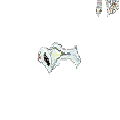

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_tynamo.png_34d8cb47-552c-4335-b307-ee50fed1a3e3.png


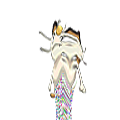

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_meowth.png_99da953c-b8d1-4ac2-8420-2d6f1335b844.png


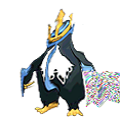

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_empoleon.png_98743cb8-b0a3-44ca-bfd3-ffd1724aecb3.png


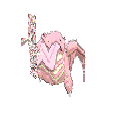

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_lickitung.png_f4128d8a-1a31-4c06-820b-ca7139047bb2.png


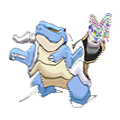

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_blastoise.png_afdd40ad-0753-4528-b9ee-ff9f9936a1bc.png


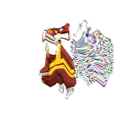

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_watchog.png_1e2bde87-3662-4988-addd-ed087f8602b0.png


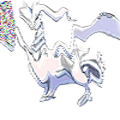

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_reshiram.png_e2e9bbf2-5a56-4926-9315-183f8e796764.png


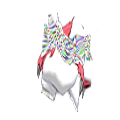

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_zangoose.png_11ab44e0-d5ac-4956-b82a-69ff3ef7c239.png


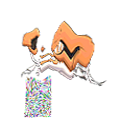

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_kingler.png_9d368894-05d1-4be4-b9a4-50e2ac8e5ccd.png


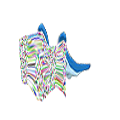

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_mantyke.png_7d0dcd2a-a9f3-4ec7-8b56-39ea38b41055.png


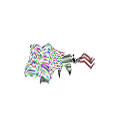

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_anorith.png_1c792081-8c93-404c-a3e8-f17917a8bbd7.png


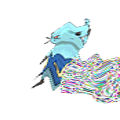

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_dewott.png_e88f2586-aaf8-44d5-819d-747d59bae19f.png


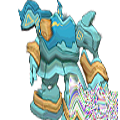

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_golurk.png_de44bca3-2066-407d-9faf-e52b0cf5b8ff.png


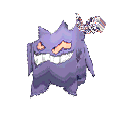

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_gengar.png_a64ba004-2609-44b3-bb6f-720c1fac817d.png


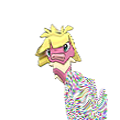

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_smoochum.png_8950085c-83d7-472a-8512-ab7961eec12e.png


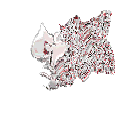

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_minccino.png_84a41d6e-7b65-473b-bb75-e8868f38051a.png


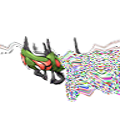

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_yanmega.png_8a3684d1-972a-4d64-bec2-b29aa744afdc.png


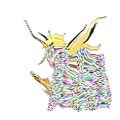

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_zapdos.png_390a7f56-d066-487a-9e14-715705fd474e.png


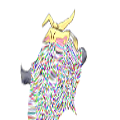

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_makuhita.png_8b4970a8-0af4-4b63-86aa-88a45d4e53d3.png


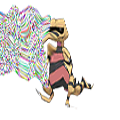

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_krokorok.png_48273cdc-c9fa-485d-8ec5-162dbfd717d0.png


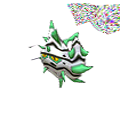

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_ferroseed.png_249d54a4-dba7-4e21-a07d-5697cf374f13.png


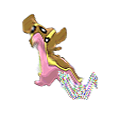

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_gastrodon.png_6d6bd533-e90c-49c3-b0ff-0cbbc0e415df.png


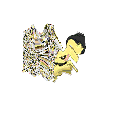

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_pichu.png_1918ccfd-7b40-4e98-a5ee-204f9506121c.png


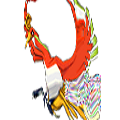

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_ho-oh.png_48a084c1-e076-4c8e-97db-f93880d388c0.png


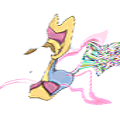

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_cresselia.png_286265f5-0999-4365-8abc-4cefe1bf3f19.png


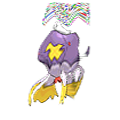

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_drifblim.png_614bbf84-f1f0-4c24-bf50-a5935f469c08.png


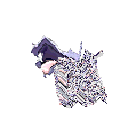

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_shellder.png_188b57a3-b168-4720-990f-528f2fecd5d1.png


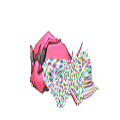

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_venipede.png_0e2505e2-a7d5-4f62-983b-afce7f2ecbab.png


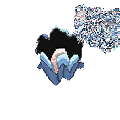

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_clamperl.png_39ef787b-6636-49a2-9b2b-3da158d086de.png


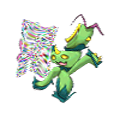

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_maractus.png_98587981-b48c-4468-a611-76a3e9eea47d.png


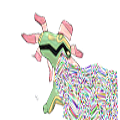

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_cradily.png_4b947064-cb85-4399-ba28-44dbec4bce6f.png


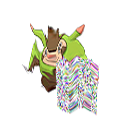

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_quilladin.png_15a7b2cc-04f6-45be-a494-9b804f6da0f7.png


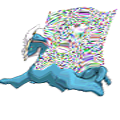

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_walrein.png_6a84cba7-3d5f-4095-92c6-0725e70ccb5b.png


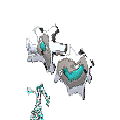

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_klink.png_703ee49a-1bb8-4bc2-a6b4-f3f70b3cf57a.png


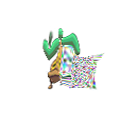

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_bonsly.png_60ec62a4-14b2-45bd-a4bb-5b18f28248b1.png


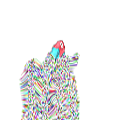

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_porygon.png_e0bef108-c52d-47a9-a9d3-4e5b7ad769d7.png


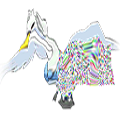

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_swanna.png_5c012626-eb4a-414e-b25a-7c8821225226.png


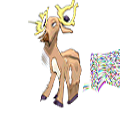

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_stantler.png_c22a5091-27d1-4512-854b-ffc59b0947be.png


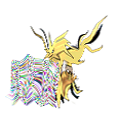

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_zapdos.png_105ab215-ae0d-4ace-b79a-2426a5756574.png


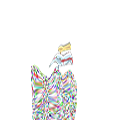

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_chimecho.png_c636cd6f-08d2-42e2-91f1-7ca4025d71d5.png


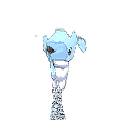

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_cubchoo.png_f2d10195-94ce-4273-9277-fed3930187c0.png


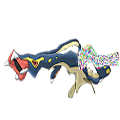

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_eelektross.png_a24c4438-1922-4da2-b8c1-0340ddbe8455.png


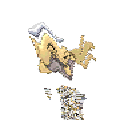

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_shedinja.png_121949cd-0b1c-4de8-b6dd-d28896e78d2d.png


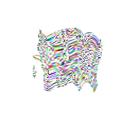

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_togepi.png_d869bdf5-8fa5-4def-9c2e-135e522dc698.png


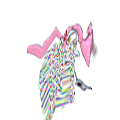

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_mesprit.png_4aef290a-1ded-4428-89c3-0ddb3aa13b72.png


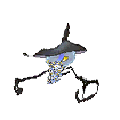

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_lampent.png_e3a6f278-c661-4d56-a788-69512cc3f0dd.png


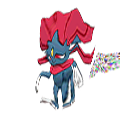

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_weavile.png_0eb46408-168d-4fff-8527-cbe8669eed23.png


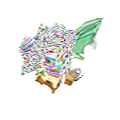

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_leafeon.png_d5ec99a5-9361-40db-929c-fdc423e0d530.png


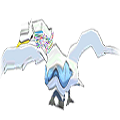

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_swanna.png_a2560113-ce80-4ab5-b082-eb4ed3f51c98.png


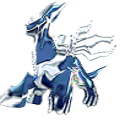

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_dialga.png_34024342-16c7-492b-acc4-7e3908603b17.png


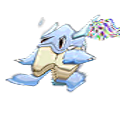

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_wartortle.png_e6554e28-973d-4229-81a2-786c97e273d9.png


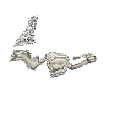

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_geodude.png_2410fa73-3a70-47a8-8a3b-e04ed91056c1.png


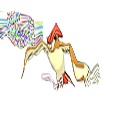

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_pidgeotto.png_6bbfeba2-bf2b-46df-a02c-20334af81a52.png


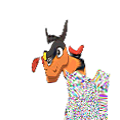

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_tepig.png_ed521fa9-683f-47c4-ac23-64f1b343ff3a.png


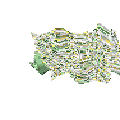

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_gulpin.png_20d36b39-3dbc-43f3-ac7a-6df759303ad0.png


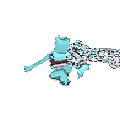

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_wynaut.png_6f3ae5ff-6562-453e-8c39-0092af78c66e.png


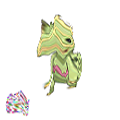

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_kecleon.png_2516423d-3b31-4a44-a407-2558e333aaa2.png


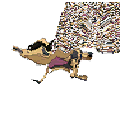

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_sandile.png_3be7e88c-9d88-4fdc-8caa-b686ef556a97.png


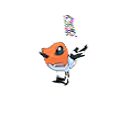

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_fletchling.png_dfbf8981-f4ac-4b3d-b75a-be979dddd9c9.png


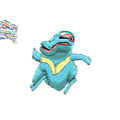

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_totodile.png_d0fd8b9d-52c0-4904-aaee-8851966fceba.png


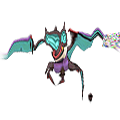

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_noivern.png_f7d24216-7e27-458d-a666-8dd66f9ce413.png


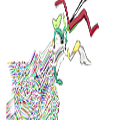

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_floette.png_7c691914-d68f-40a8-8371-ff615ad2a60d.png


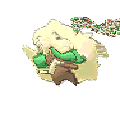

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_whimsicott.png_528efb24-6735-4ac9-95fd-910355c0a0ec.png


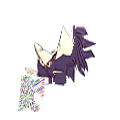

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_stunky.png_5315115a-40e8-4ad5-9a97-2c28ce6c578e.png


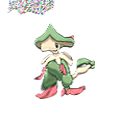

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_breloom.png_3cae89a5-d8cf-470f-b4c3-009ac302bfe7.png


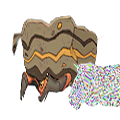

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_crustle.png_31c9b519-a11d-48c3-a53c-2db5ec6ff461.png


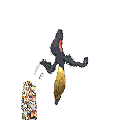

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_yamask.png_a4188a28-2b03-4afe-a0f6-c088dc8eea42.png


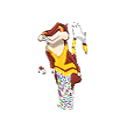

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_watchog.png_633b4f44-4a8e-4559-8891-419eece61f20.png


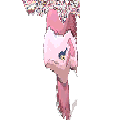

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_alomomola.png_f3d8d697-0103-40e6-b027-2f1861de880f.png


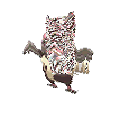

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_vullaby.png_503a5235-06e0-48f5-b1c2-94d4202f881c.png


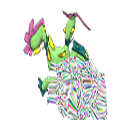

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_maractus.png_ec47de66-1c30-490b-a4ac-1b355cd2d4f3.png


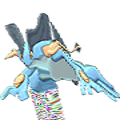

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_swampert.png_4d471d7c-560b-48dc-ae57-e66ae218ae7a.png


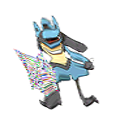

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_lucario.png_7a31c441-1da1-434a-9d33-be0e480cd562.png


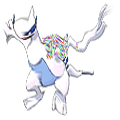

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_lugia.png_b15dd50b-2d0b-42c1-8a1b-b436ede9c3b8.png


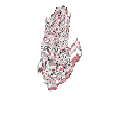

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_happiny.png_f89e955c-de09-4697-89f8-615a593e3940.png


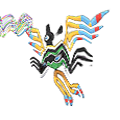

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_sigilyph.png_03c677e6-b31a-49e4-93b9-53489c09307b.png


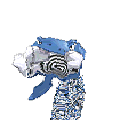

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_poliwrath.png_426b17c8-761a-43f9-94a7-0cf1a06c41c2.png


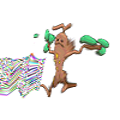

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_sudowoodo.png_ef4aa3cf-296e-4caf-8be7-4ce7a51b25fc.png


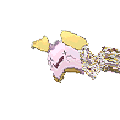

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_whismur.png_c4ebed7a-7617-4fd5-82b9-2e5ee364bdc4.png


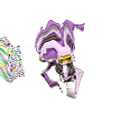

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_noibat.png_b02f21c6-2af4-46e4-b532-17692b12697e.png


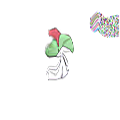

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_ralts.png_8993b644-1764-4c77-8daa-8605cf193ba5.png


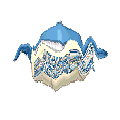

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_wailmer.png_3c491b86-61b1-4b21-be08-302be869e5d0.png


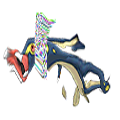

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_eelektross.png_ac6e0cd3-5ffd-4b2d-a215-2f2c8b068f3e.png


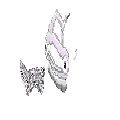

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_castform.png_39a3369c-1d4b-46fd-9bfc-0ff8d1ef63ce.png


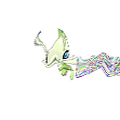

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_celebi.png_f56ca323-a156-4585-8b91-c9bc26ab03a0.png


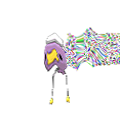

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_drifloon.png_5be317cd-0b39-4f0b-a393-23e53ea79ef3.png


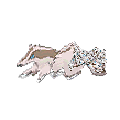

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_linoone.png_f891131f-63e7-4e3a-8634-863ef6442860.png


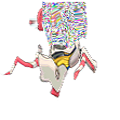

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_escavalier.png_87299252-b0f6-4a97-af2d-4aadfd8253fc.png


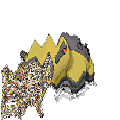

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_hippowdon.png_c8dab2ac-8ba0-4804-a4b9-18208c8dbf5e.png


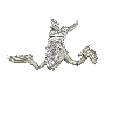

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_geodude.png_b3f49645-44b8-4ca7-acd1-5b11cb3d8675.png


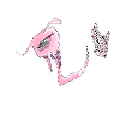

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_gorebyss.png_3706fcb2-27d6-400b-9f15-86c8b48cbc0b.png


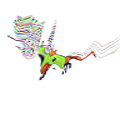

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_yanma.png_724f887f-aac0-4efe-ad68-470124b374af.png


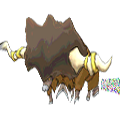

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_bouffalant.png_d08b1fd4-31d9-48d1-8042-ec7fa2cd15b0.png


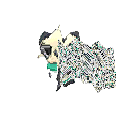

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_pancham.png_33eef6de-16f3-41e7-855f-479209dbd07b.png


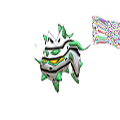

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_ferroseed.png_4fe680f6-a067-41d6-b430-ab0a7ecfb3b7.png


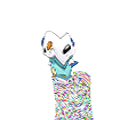

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_oshawott.png_f254d350-9924-4b02-86eb-67910b7f0212.png


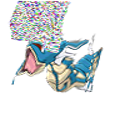

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_gyarados.png_385a39d5-e2a8-455c-9753-35cb93ad7d73.png


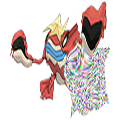

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_crawdaunt.png_d059c051-aaa6-4aa4-886f-6c36ae7b6240.png


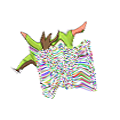

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_quilladin.png_ca2699d6-fd63-450c-b51f-0d6db7e5f2e7.png


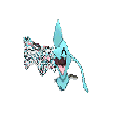

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_wynaut.png_b095f922-5f43-4784-b12f-e940176ccbb5.png


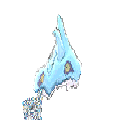

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_bergmite.png_bc82a86c-d4f9-44e7-a421-576b700c43ff.png


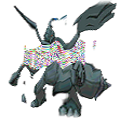

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_zekrom.png_af807dc9-655e-47a6-95ee-c13bee865f82.png


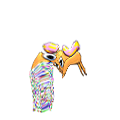

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_paras.png_ad460981-a590-4d34-aa79-0e653ca820eb.png


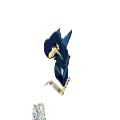

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_murkrow.png_e0d4e44c-266e-458c-ac39-40179f5f5342.png


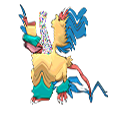

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_archeops.png_3ade13a8-b2ac-4028-9d29-b878ae8400c6.png


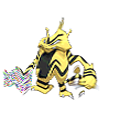

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_electabuzz.png_98c75aa6-47d1-4798-8604-2226df586850.png


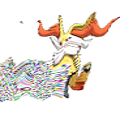

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_braixen.png_d800d114-45c5-4f71-82d0-ef6890296472.png


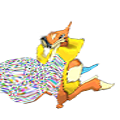

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_floatzel.png_97694a7f-72a6-4d71-ab1a-52fdebef9288.png


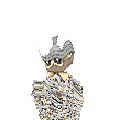

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_seedot.png_d0b25ea4-3bd6-418f-9cb2-5bea40bac402.png


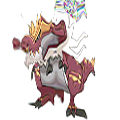

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_tyrantrum.png_9d94a794-336f-4aa3-8931-9b7b70044a54.png


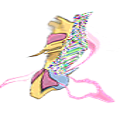

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_cresselia.png_e2ad3dbc-c56e-46e9-95af-94e3edd94f4f.png


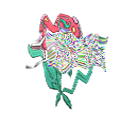

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_florges.png_e5e6e095-d41d-4321-9fe3-3a92cf8f9ca3.png


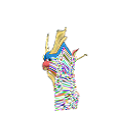

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_carvanha.png_46307a1e-3087-4ded-a4ff-06e64cd24060.png


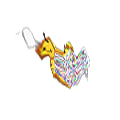

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_combee.png_3218d876-1702-4ace-924b-51493f192bc7.png


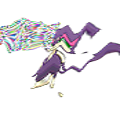

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_purrloin.png_0ef14a99-d7de-4b31-8a84-42e486299676.png


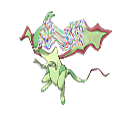

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_flygon.png_c0db7635-67a6-453f-b17f-b8efe2e11ff0.png


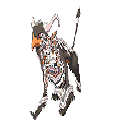

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_houndoom.png_bcf6a15a-9f17-4e1c-9c14-0869ba4f60ef.png


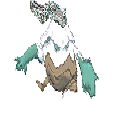

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_snover.png_8776d896-3a3f-430b-8254-2d3f0309bf16.png


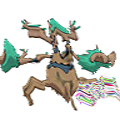

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_trevenant.png_8152a19b-e4ae-4090-bdfe-b36b33b1664f.png


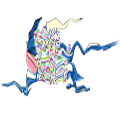

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_greninja.png_a2a38d64-0d15-4a21-b9bb-e144576e6ebc.png


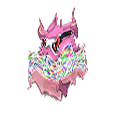

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_aromatisse.png_94369bfe-110e-4736-a27d-07ab6da8d2d9.png


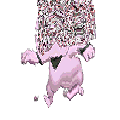

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_granbull.png_a44bc9e1-951a-4db0-bc02-58282dccc871.png


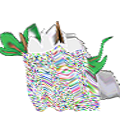

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_shiftry.png_e16954c5-bdfd-4b88-8b44-24c96fff9bbd.png


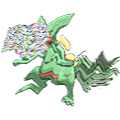

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_sceptile.png_9fbccb06-c9cc-4017-8893-2187a7ce6511.png


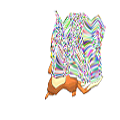

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_buizel.png_d6b62c23-b545-498c-a156-05fb275c5eab.png


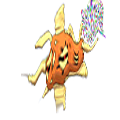

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_solrock.png_22528d90-0e25-4887-bb24-d71cd073cf9d.png


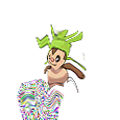

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_chespin.png_1803db26-cb70-4c6a-ba99-ee421c1fb492.png


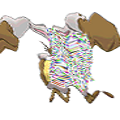

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_diggersby.png_3af6f0b6-4962-4edd-8edf-3dbfc7e059f0.png


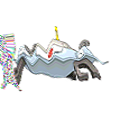

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_magnezone.png_c4215a84-85f6-4af3-8fe7-f842eb7e2885.png


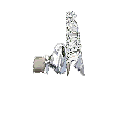

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_nincada.png_dcacc7de-a891-40a5-8ba1-cd31720a883b.png


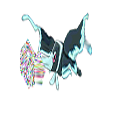

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_lumineon.png_fe453538-ccd3-4f8c-87ee-dab934c2ad09.png


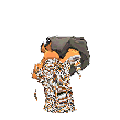

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_dwebble.png_3afd3eb1-6a50-4bb7-82a9-983c4264c423.png


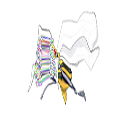

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_beedrill.png_88ee01f4-c18d-4754-a616-5af985b39e12.png


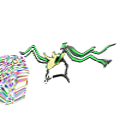

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_vibrava.png_99bc047f-cb2a-40f0-a980-54e8c6dfc4a8.png


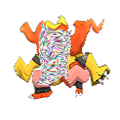

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_magmortar.png_268336bd-a0e4-4b64-8013-5e2a2c910497.png


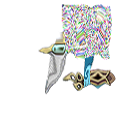

/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/images_original_honedge.png_6cc570a8-f0be-46a2-8aa0-fb2cdf9faa7c.png


In [19]:
import glob
from IPython.display import Image, display
for imageName in glob.glob('/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/archive/images/output/*.png'): #assuming JPG
    display(Image(filename=imageName))
    print(imageName)

## Variational Autoencoders <a class="anchor" id="VAE"></a>

Variational Autoencoder is an autoencoder whose training is regularized to avoid overfitting and ensure that the latent space has good properties that enable generative process. The idea is instead of mapping the input into a fixed vector, we want to map it into a distribution. In other words, the encoder outputs two vectors of size nn, a vector of means μ, and another vector of standard variations σ.

In [20]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Conv2DTranspose, Flatten
from tensorflow.keras.layers import Reshape, BatchNormalization, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import TensorBoard

# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sample_z(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """
    mu, sigma = args
    batch     = K.shape(mu)[0]
    dim       = K.int_shape(mu)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    eps       = K.random_normal(shape=(batch, dim))
    return mu + K.exp(sigma / 2) * eps



image_width  = 64
image_height = 64
latent_dim   = 2
no_epochs    = 15
batch_size   = 128
num_channels = 1

# Defining the encoder
inputs = Input(shape=(image_width, image_height, 1), name='encoder_input')  

x = Conv2D(32, (3, 3), activation='relu', strides=2, padding='same')(inputs)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', strides=2, padding='same')(x)
x = BatchNormalization()(x)
conv_shape = K.int_shape(x)
x = Flatten()(x)
x = Dense(16)(x)
x = BatchNormalization()(x)
mu = Dense(latent_dim, name='latent_mu')(x)
sigma = Dense(latent_dim, name='latent_sigma')(x)

# use reparameterization trick to push the sampling out as input
z  = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([mu, sigma])


encoder = Model(inputs, [mu, sigma, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d_2 (Conv2D)              (None, 32, 32, 32)   320         ['encoder_input[0][0]']          
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 32)  128         ['conv2d_2[0][0]']               
 alization)                                                                                       
                                                                                                  
 conv2d_3 (Conv2D)              (None, 16, 16, 64)   18496       ['batch_normalization[0][0]

#### Define the Decoder

In [21]:
# Defining decoder
d_i   = Input(shape=(latent_dim, ), name='decoder_input')
x     = Dense(conv_shape[1] * conv_shape[2] * conv_shape[3], activation='relu')(d_i)
x     = BatchNormalization()(x)
x     = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
cx    = Conv2DTranspose(16, (3, 3), strides=2, padding='same', activation='relu')(x)
cx    = BatchNormalization()(cx)
cx    = Conv2DTranspose(8, (3, 3), strides=2, padding='same',  activation='relu')(cx)
cx    = BatchNormalization()(cx)
o     = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same', name='decoder_output')(cx)

# Instantiate decoder
decoder = Model(d_i, o, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense_3 (Dense)             (None, 16384)             49152     
                                                                 
 batch_normalization_3 (Batc  (None, 16384)            65536     
 hNormalization)                                                 
                                                                 
 reshape_1 (Reshape)         (None, 16, 16, 64)        0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 32, 32, 16)       9232      
 ranspose)                                                       
                                                                 
 batch_normalization_4 (Batc  (None, 32, 32, 16)       64  

#### Build VAE model

In [22]:
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')
vae.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 64, 64, 1)]       0         
                                                                 
 encoder (Functional)        [(None, 2),               281492    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 64, 64, 1)         125249    
                                                                 
Total params: 406,741
Trainable params: 373,701
Non-trainable params: 33,040
_________________________________________________________________


In [23]:
def vae_loss(true, pred):
    # Reconstruction loss
    reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred)) * image_width * image_height
    # KL divergence loss
    kl_loss = 1 + sigma - K.square(mu) - K.exp(sigma)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    # Total loss = 50% rec + 50% KL divergence loss
    return K.mean(reconstruction_loss + kl_loss)

<ipython-input-25-454a0f95aaf5>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(2,2))


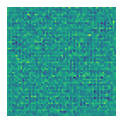

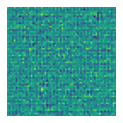

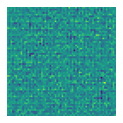

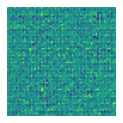

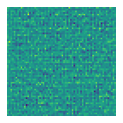

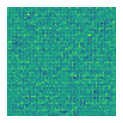

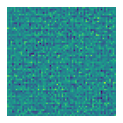

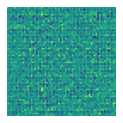

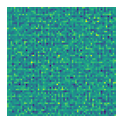

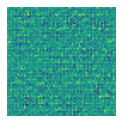

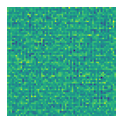

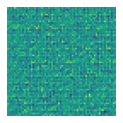

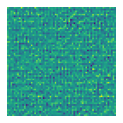

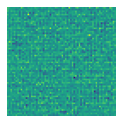

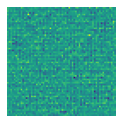

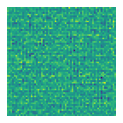

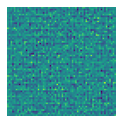

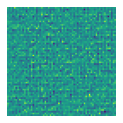

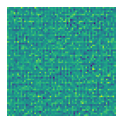

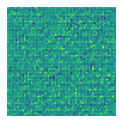

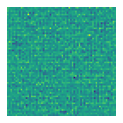

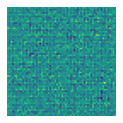

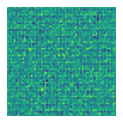

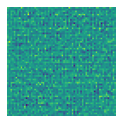

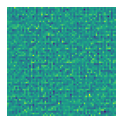

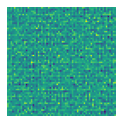

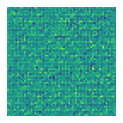

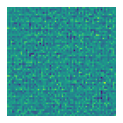

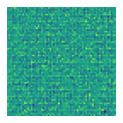

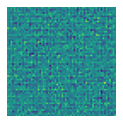

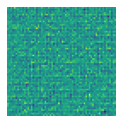

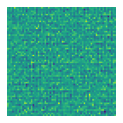

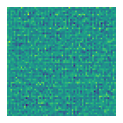

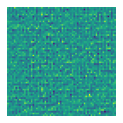

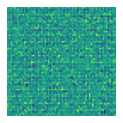

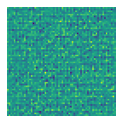

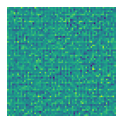

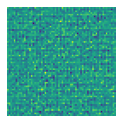

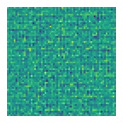

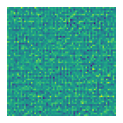

In [25]:
# Randomly sample one or more charachters and plot them
random_chars = [np.random.normal(0, 1, latent_dim) for _ in range(40)]
imgs = []
for char in random_chars:
    char = char.reshape(-1,2)
    imgs.append(decoder.predict(char))

imgs = [np.reshape(img,(image_width, image_height)) for img in imgs]
for img in imgs:
    plt.figure(figsize=(2,2))
    plt.axis('off')
    plt.imshow(img)

## Generative Adversarial Networks <a class="anchor" id="GAN"></a>

A generative adversarial network is a machine learning (ML) model in which two neural networks compete with each other to become more accurate in their predictions. GANs typically run unsupervised and use a cooperative zero-sum game framework to learn.

The two neural networks that make up a GAN are referred to as the generator and the discriminator. The generator is a convolutional neural network and the discriminator is a deconvolutional neural network. The goal of the generator is to artificially manufacture outputs that could easily be mistaken for real data. The goal of the discriminator is to identify which outputs it receives have been artificially created.

#### Import essential Libraries

In [26]:
# To generate GIFs
%pip install imageio
%pip install git+https://github.com/tensorflow/docs
import numpy as np

import zipfile
import os
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import gridspec
import tensorflow as tf
from tensorflow.keras import layers
import time
from IPython import display
# To generate GIFs
import glob
import imageio

Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/tensorflow/docs to /private/var/folders/cl/hp9dr3bd4cndwdxx568xdw5m0000gn/T/pip-req-build-hjxchbmv
  Running command git clone -q https://github.com/tensorflow/docs /private/var/folders/cl/hp9dr3bd4cndwdxx568xdw5m0000gn/T/pip-req-build-hjxchbmv
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=154992 sha256=a78f2c9c747d714f7b7e2975fabd05c9bdf9cd717142130809ada8589380c451
  Stored in directory: /private/var/folders/cl/hp9dr3bd4cndwdxx568xdw5m0000gn/T/pip-ephem-wheel-cache-f2n8_7l3/wheels/3b/ee/a2/ab4d36a9a4af495bcb936f3e849d4b497b65fa40548a68d6c3
Successfully built tensorflow-docs
Note: you may need to restart the kernel to use updated packages.


#### Prepare Images Data for training

In [68]:
train_dir = "/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/GAN/"
fnames = os.listdir(train_dir)
filepaths = [train_dir + fname for fname in fnames]

In [69]:
IMG_SIZE = 120
BATCH_SIZE = 8
BUFFER_SIZE = 809       # number of pokemon in our dataset

In [70]:
def modify_background(filepath):
    png = Image.open(filepath).convert('RGBA')
    png.load() # required for png.split()

    modified_img = Image.new("RGB", png.size, (0, 0, 0))   # (0, 0, 0) for a black background
    modified_img.paste(png, mask=png.split()[-1])          # the last index is the alpha channel

    return modified_img

In [71]:
def preprocess(filepath):
    img = modify_background(filepath)
    img = tf.keras.preprocessing.image.img_to_array(img)    # converting the PIL image into a Numpy array
    img = (img - 127.5) / 127.5                             # rescaling the RGB values to be between -1 and 1
    return img

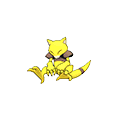

In [72]:
og = Image.open('/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/GAN/abra.png')
og

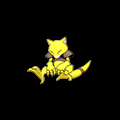

In [73]:
modified = preprocess('/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/GAN/abra.png')
modified = tf.keras.preprocessing.image.array_to_img(modified)    # converting the Numpy array back into a PIL image
modified

In [117]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import time
import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
from glob import glob
import datetime
import random
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

Instructions for updating:
non-resource variables are not supported in the long term


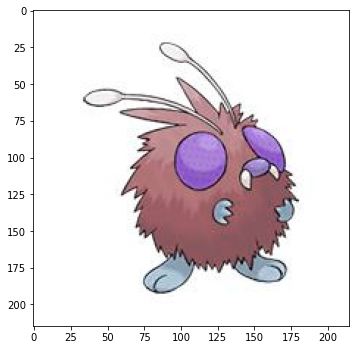

In [118]:
path = '/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/data_ready/'

plt.figure(figsize = (5,5))
img = cv2.imread('/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/data_ready/Pkmn_img90.JPG')
plt.imshow(img)
plt.tight_layout()

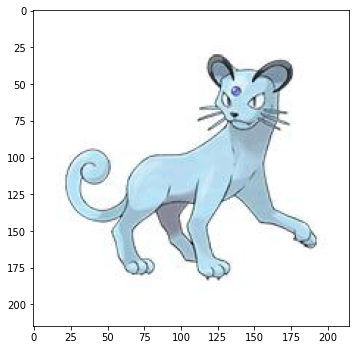

In [119]:
plt.figure(figsize = (5,5))
img = cv2.imread('/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/data_ready/Pkmn_img97.JPG')
plt.imshow(img)
plt.tight_layout()

#### Define Generator Model

In [120]:
def generator(z, output_channel_dim, training):
    with tf.variable_scope("generator", reuse= not training):
        
        # 8x8x1024
        fully_connected = tf.layers.dense(z, 8*8*1024)
        fully_connected = tf.reshape(fully_connected, (-1, 8, 8, 1024))
        fully_connected = tf.nn.leaky_relu(fully_connected)

        # 8x8x1024 -> 16x16x512
        trans_conv1 = tf.layers.conv2d_transpose(inputs=fully_connected,
                                                 filters=512,
                                                 kernel_size=[5,5],
                                                 strides=[2,2],
                                                 padding="SAME",
                                                 kernel_initializer=tf.truncated_normal_initializer(stddev=WEIGHT_INIT_STDDEV),
                                                 name="trans_conv1")
        batch_trans_conv1 = tf.layers.batch_normalization(inputs = trans_conv1,
                                                          training=training,
                                                          epsilon=EPSILON,
                                                          name="batch_trans_conv1")
        
        
        trans_conv1_out = tf.nn.leaky_relu(batch_trans_conv1,
                                           name="trans_conv1_out")
        
        # 16x16x512 -> 32x32x256
        trans_conv2 = tf.layers.conv2d_transpose(inputs=trans_conv1_out,
                                                 filters=256,
                                                 kernel_size=[5,5],
                                                 strides=[2,2],
                                                 padding="SAME",
                                                 kernel_initializer=tf.truncated_normal_initializer(stddev=WEIGHT_INIT_STDDEV),
                                                 name="trans_conv2")
        batch_trans_conv2 = tf.layers.batch_normalization(inputs = trans_conv2,
                                                          training=training,
                                                          epsilon=EPSILON,
                                                          name="batch_trans_conv2")
        
        trans_conv2_out = tf.nn.leaky_relu(batch_trans_conv2,
                                           name="trans_conv2_out")
        
        # 32x32x256 -> 64x64x128
        trans_conv3 = tf.layers.conv2d_transpose(inputs=trans_conv2_out,
                                                 filters=128,
                                                 kernel_size=[5,5],
                                                 strides=[2,2],
                                                 padding="SAME",
                                                 kernel_initializer=tf.truncated_normal_initializer(stddev=WEIGHT_INIT_STDDEV),
                                                 name="trans_conv3")
        batch_trans_conv3 = tf.layers.batch_normalization(inputs = trans_conv3,
                                                          training=training,
                                                          epsilon=EPSILON,
                                                          name="batch_trans_conv3")
        trans_conv3_out = tf.nn.leaky_relu(batch_trans_conv3,
                                           name="trans_conv3_out")
        
        
        # 64x64x128 -> 128x128x64
        trans_conv4 = tf.layers.conv2d_transpose(inputs=trans_conv3_out,
                                                 filters=64,
                                                 kernel_size=[5,5],
                                                 strides=[2,2],
                                                 padding="SAME",
                                                 kernel_initializer=tf.truncated_normal_initializer(stddev=WEIGHT_INIT_STDDEV),
                                                 name="trans_conv4")
        batch_trans_conv4 = tf.layers.batch_normalization(inputs = trans_conv4,
                                                          training=training,
                                                          epsilon=EPSILON,
                                                          name="batch_trans_conv4")
        trans_conv4_out = tf.nn.leaky_relu(batch_trans_conv4,
                                           name="trans_conv4_out")
        
        # 128x128x64 -> 128x128x3
        logits = tf.layers.conv2d_transpose(inputs=trans_conv4_out,
                                            filters=3,
                                            kernel_size=[5,5],
                                            strides=[1,1],
                                            padding="SAME",
                                            kernel_initializer=tf.truncated_normal_initializer(stddev=WEIGHT_INIT_STDDEV),
                                            name="logits")
        out = tf.tanh(logits, name="out")
        return out

#### Define Discriminator Model

In [121]:
def discriminator(x, reuse):
    with tf.variable_scope("discriminator", reuse=reuse): 
        
        # 128*128*3 -> 64x64x64 
        conv1 = tf.layers.conv2d(inputs=x,
                                 filters=64,
                                 kernel_size=[5,5],
                                 strides=[2,2],
                                 padding="SAME",
                                 kernel_initializer=tf.truncated_normal_initializer(stddev=WEIGHT_INIT_STDDEV),
                                 name='conv1')
        batch_norm1 = tf.layers.batch_normalization(conv1,
                                                    training=True,
                                                    epsilon=EPSILON,
                                                    name='batch_norm1')
        conv1_out = tf.nn.leaky_relu(batch_norm1,
                                     name="conv1_out")
        
        # 64x64x64-> 32x32x128 
        conv2 = tf.layers.conv2d(inputs=conv1_out,
                                 filters=128,
                                 kernel_size=[5, 5],
                                 strides=[2, 2],
                                 padding="SAME",
                                 kernel_initializer=tf.truncated_normal_initializer(stddev=WEIGHT_INIT_STDDEV),
                                 name='conv2')
        batch_norm2 = tf.layers.batch_normalization(conv2,
                                                    training=True,
                                                    epsilon=EPSILON,
                                                    name='batch_norm2')
        conv2_out = tf.nn.leaky_relu(batch_norm2,
                                     name="conv2_out")
        
        # 32x32x128 -> 16x16x256  
        conv3 = tf.layers.conv2d(inputs=conv2_out,
                                 filters=256,
                                 kernel_size=[5, 5],
                                 strides=[2, 2],
                                 padding="SAME",
                                 kernel_initializer=tf.truncated_normal_initializer(stddev=WEIGHT_INIT_STDDEV),
                                 name='conv3')
        batch_norm3 = tf.layers.batch_normalization(conv3,
                                                    training=True,
                                                    epsilon=EPSILON,
                                                    name='batch_norm3')
        conv3_out = tf.nn.leaky_relu(batch_norm3,
                                     name="conv3_out")
        
        
        # 16x16x256 -> 16x16x512
        conv4 = tf.layers.conv2d(inputs=conv3_out,
                                 filters=512,
                                 kernel_size=[5, 5],
                                 strides=[1, 1],
                                 padding="SAME",
                                 kernel_initializer=tf.truncated_normal_initializer(stddev=WEIGHT_INIT_STDDEV),
                                 name='conv4')
        batch_norm4 = tf.layers.batch_normalization(conv4,
                                                    training=True,
                                                    epsilon=EPSILON,
                                                    name='batch_norm4')
        conv4_out = tf.nn.leaky_relu(batch_norm4,
                                     name="conv4_out")
        
        
        # 16x16x512 -> 8x8x1024
        conv5 = tf.layers.conv2d(inputs=conv4_out,
                                filters=1024,
                                kernel_size=[5, 5],
                                strides=[2, 2],
                                padding="SAME",
                                kernel_initializer=tf.truncated_normal_initializer(stddev=WEIGHT_INIT_STDDEV),
                                name='conv5')
        batch_norm5 = tf.layers.batch_normalization(conv5,
                                                    training=True,
                                                    epsilon=EPSILON,
                                                    name='batch_norm5')
        conv5_out = tf.nn.leaky_relu(batch_norm5,
                                     name="conv5_out")
        
        
        flatten = tf.reshape(conv5_out, (-1, 8*8*1024))
        logits = tf.layers.dense(inputs=flatten,
                                 units=1,
                                 activation=None)
        out = tf.sigmoid(logits)
        return out, logits

#### Define Model Loss

In [122]:
def model_loss(input_real, input_z, output_channel_dim):
    g_model = generator(input_z, output_channel_dim, True)

    noisy_input_real = input_real + tf.random_normal(shape=tf.shape(input_real),
                                                     mean=0.0,
                                                     stddev=random.uniform(0.0, 0.1),
                                                     dtype=tf.float32)
    
    d_model_real, d_logits_real = discriminator(noisy_input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                         labels=tf.ones_like(d_model_real)*random.uniform(0.9, 1.0)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    d_loss = tf.reduce_mean(0.5 * (d_loss_real + d_loss_fake))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                    labels=tf.ones_like(d_model_fake)))
    return d_loss, g_loss                                                                                                                            

#### Define Optimizers Model 

In [123]:
def model_optimizers(d_loss, g_loss):
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith("generator")]
    d_vars = [var for var in t_vars if var.name.startswith("discriminator")]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    gen_updates = [op for op in update_ops if op.name.startswith('generator')]
    
    with tf.control_dependencies(gen_updates):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=LR_D, beta1=BETA1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=LR_G, beta1=BETA1).minimize(g_loss, var_list=g_vars)  
    return d_train_opt, g_train_opt

In [124]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    learning_rate_G = tf.placeholder(tf.float32, name="lr_g")
    learning_rate_D = tf.placeholder(tf.float32, name="lr_d")
    return inputs_real, inputs_z, learning_rate_G, learning_rate_D

In [125]:
def show_samples(sample_images, name, epoch):
    figure, axes = plt.subplots(1, len(sample_images), figsize = (IMAGE_SIZE, IMAGE_SIZE))
    for index, axis in enumerate(axes):
        axis.axis('off')
        image_array = sample_images[index]
        axis.imshow(image_array)
        image = Image.fromarray(image_array)
        image.save(name+"_"+str(epoch)+"_"+str(index)+".JPG") 
    plt.savefig(name+"_"+str(epoch)+".JPG", bbox_inches='tight', pad_inches=0)
    plt.show()
    plt.close()

In [126]:
def test(sess, input_z, out_channel_dim, epoch):
    example_z = np.random.uniform(-1, 1, size=[SAMPLES_TO_SHOW, input_z.get_shape().as_list()[-1]])
    samples = sess.run(generator(input_z, out_channel_dim, False), feed_dict={input_z: example_z})
    sample_images = [((sample + 1.0) * 127.5).astype(np.uint8) for sample in samples]
    show_samples(sample_images, OUTPUT_DIR + "samples", epoch)

In [127]:
def summarize_epoch(epoch, duration, sess, d_losses, g_losses, input_z, data_shape):
    minibatch_size = int(data_shape[0]//BATCH_SIZE)
    print("Epoch {}/{}".format(epoch, EPOCHS),
          "\nDuration: {:.5f}".format(duration),
          "\nD Loss: {:.5f}".format(np.mean(d_losses[-minibatch_size:])),
          "\nG Loss: {:.5f}".format(np.mean(g_losses[-minibatch_size:])))
    fig, ax = plt.subplots()
    plt.plot(d_losses, label='Discriminator', alpha=0.6)
    plt.plot(g_losses, label='Generator', alpha=0.6)
    plt.title("Losses")
    plt.legend()
    plt.savefig(OUTPUT_DIR + "losses_" + str(epoch) + ".JPG")
    plt.show()
    plt.close()
    test(sess, input_z, data_shape[3], epoch)

In [128]:
def get_batches(data):
    batches = []
    for i in range(int(data.shape[0]//BATCH_SIZE)):
        batch = data[i * BATCH_SIZE:(i + 1) * BATCH_SIZE]
        augmented_images = []
        for img in batch:
            image = Image.fromarray(img)
            if random.choice([True, False]):
                image = image.transpose(Image.FLIP_LEFT_RIGHT)
            augmented_images.append(np.asarray(image))
        batch = np.asarray(augmented_images)
        normalized_batch = (batch / 127.5) - 1.0
        batches.append(normalized_batch)
    return batches

In [129]:
def train(get_batches, data_shape, checkpoint_to_load=None):
    input_images, input_z, lr_G, lr_D = model_inputs(data_shape[1:], NOISE_SIZE)
    d_loss, g_loss = model_loss(input_images, input_z, data_shape[3])
    d_opt, g_opt = model_optimizers(d_loss, g_loss)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        epoch = 0
        iteration = 0
        d_losses = []
        g_losses = []
        
        for epoch in range(EPOCHS):        
            epoch += 1
            start_time = time.time()
            
            for epoch in range(EPOCHS):        
                epoch += 1
                start_time = time.time()

            for batch_images in get_batches:
                iteration += 1
                batch_z = np.random.uniform(-1, 1, size=(BATCH_SIZE, NOISE_SIZE))
                _ = sess.run(d_opt, feed_dict={input_images: batch_images, input_z: batch_z, lr_D: LR_D})
                _ = sess.run(g_opt, feed_dict={input_images: batch_images, input_z: batch_z, lr_G: LR_G})
                d_losses.append(d_loss.eval({input_z: batch_z, input_images: batch_images}))
                g_losses.append(g_loss.eval({input_z: batch_z}))

            summarize_epoch(epoch, time.time()-start_time, sess, d_losses, g_losses, input_z, data_shape)

In [130]:
# Paths
INPUT_DATA_DIR = "/Users/shu-ya/Desktop/Documents/2021 Fall/CSYE7370/Assignment4/data_ready/"
# OUTPUT_DIR = './{date:%Y-%m-%d_%H:%M:%S}/'.format(date=datetime.datetime.now())
# if not os.path.exists(OUTPUT_DIR):
#     os.makedirs(OUTPUT_DIR)
OUTPUT_DIR = ""

#### Set Model Hyperparameters

In [131]:
# Hyperparameters
IMAGE_SIZE = 128
NOISE_SIZE = 100
LR_D = 0.00005
LR_G = 0.00005
BATCH_SIZE = 64
EPOCHS = 5 # For better results increase this value 
BETA1 = 0.5
WEIGHT_INIT_STDDEV = 0.02
EPSILON = 0.00005
SAMPLES_TO_SHOW = 7

Start!
Input: (7357, 128, 128, 3)


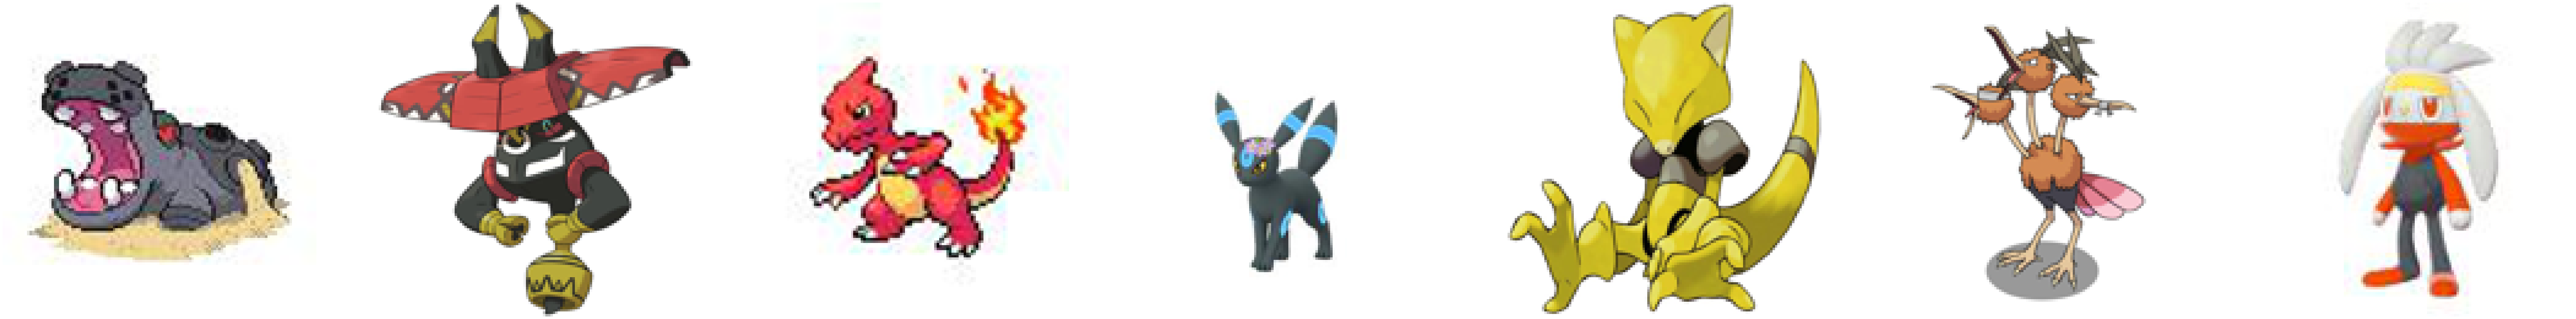

Instructions for updating:
Colocations handled automatically by placer.


<ipython-input-120-7c3b0d1a799c>:5: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  fully_connected = tf.layers.dense(z, 8*8*1024)
/Users/shu-ya/opt/anaconda3/lib/python3.8/site-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
<ipython-input-120-7c3b0d1a799c>:10: UserWarning: `tf.layers.conv2d_transpose` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2DTranspose` instead.
  trans_conv1 = tf.layers.conv2d_transpose(inputs=fully_connected,
/Users/shu-ya/opt/anaconda3/lib/python3.8/site-packages/keras/legacy_tf_layers/convolutional.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
<ipython-input-120-7c3b0d1

KeyboardInterrupt: 

In [132]:
# Training
print("Start!")
input_images = np.asarray([np.asarray(Image.open(file).resize((IMAGE_SIZE, IMAGE_SIZE))) for file in glob(INPUT_DATA_DIR + '*')])
print ("Input: " + str(input_images.shape))

np.random.shuffle(input_images)

sample_images = random.sample(list(input_images), SAMPLES_TO_SHOW)
show_samples(sample_images, OUTPUT_DIR + "inputs", 0)

with tf.Graph().as_default():
    train(get_batches(input_images), input_images.shape)

## References

## Copyright and Licensing

BSD 3-Clause License

Copyright (c) 2021, Shu-Ya Hsu
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

* Redistributions of source code must retain the above copyright notice, this
  list of conditions and the following disclaimer.

* Redistributions in binary form must reproduce the above copyright notice,
  this list of conditions and the following disclaimer in the documentation
  and/or other materials provided with the distribution.

* Neither the name of the copyright holder nor the names of its
  contributors may be used to endorse or promote products derived from
  this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

In [133]:
# Copyright (c) Hsu-Ya Hsu.
# Distributed under the terms of the 3-Clause BSD License.

You are free to use or adapt this notebook for any purpose you'd like. However, please respect the [Modified BSD License](https://jupyter.org/governance/projectlicense.html) that governs its use.